In [45]:
%tensorflow_version 2.x
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=1, 
                             factor=0.8, min_lr=1e-4)
%matplotlib inline


print("Tesorflow Version:", tf.__version__)
print("Keras Version:",keras.__version__)

Tesorflow Version: 2.1.0-rc1
Keras Version: 2.2.4-tf


In [2]:
# Dataset predefinito offerto da keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape[0], 'esempi di training')
print(x_test.shape[0], 'esempi di test')

11493376/11490434 [==============================] - 0s 0us/step
60000 esempi di training
10000 esempi di test


In [3]:
# Aggiunta dimensione canali
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print("(length, height, width, channel):",x_train.shape)

(length, height, width, channel): (60000, 28, 28, 1)


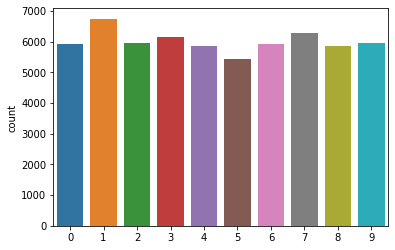

In [4]:
#classi bilanciate
sns.countplot(y_train)
plt.show()

In [0]:
# Conversione di tipo
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Conversione in forma categorica
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
x_train.shape

(60000, 28, 28, 1)

## Main assignment Problem

* Convoluzione bidimensionale con 32 filtri 3$\times$3
* ReLU
* Max pooling bidimensionale con filtro 2$\times$2
* Flattening
* Fully-connected che mappi a 128 dimensioni
* ReLU
* Fully-connected che mappi alla dimensione finale del problema

In [0]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),
                activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.05),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_decay, early])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 26us/sample - loss: 1.1291 - accuracy: 0.7413 - val_loss: 0.4427 - val_accuracy: 0.8802
Epoch 2/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.3849 - accuracy: 0.8931 - val_loss: 0.3207 - val_accuracy: 0.9138
Epoch 3/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.3149 - accuracy: 0.9093 - val_loss: 0.2774 - val_accuracy: 0.9212
Epoch 4/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2814 - accuracy: 0.9197 - val_loss: 0.2550 - val_accuracy: 0.9286
Epoch 5/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.2585 - accuracy: 0.9254 - val_loss: 0.2357 - val_accuracy: 0.9322
Epoch 6/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.2396 - accuracy: 0.9313 - val_loss: 0.2183 - val_accuracy: 0.9390
Epoch 7/50
60000/60000 [==============================] 

In [56]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print(classification_report(y_test.argmax(axis=1), 
                            model.predict(x_test).argmax(axis=1),
                            digits=4))

Test loss: 0.05996907957950607
              precision    recall  f1-score   support

           0     0.9778    0.9888    0.9833       980
           1     0.9912    0.9921    0.9916      1135
           2     0.9815    0.9767    0.9791      1032
           3     0.9852    0.9861    0.9857      1010
           4     0.9817    0.9827    0.9822       982
           5     0.9810    0.9854    0.9832       892
           6     0.9864    0.9823    0.9843       958
           7     0.9639    0.9864    0.9750      1028
           8     0.9823    0.9671    0.9747       974
           9     0.9818    0.9643    0.9730      1009

    accuracy                         0.9813     10000
   macro avg     0.9813    0.9812    0.9812     10000
weighted avg     0.9813    0.9813    0.9813     10000



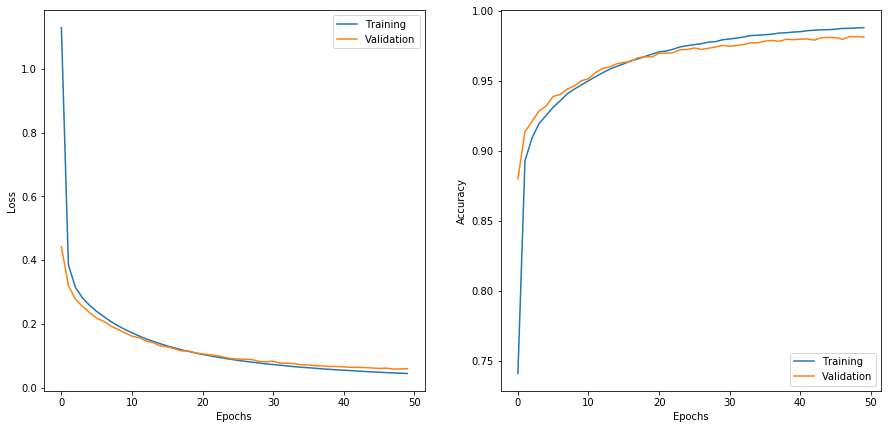

In [57]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training', 'Validation'], loc='lower right')
plt.show()

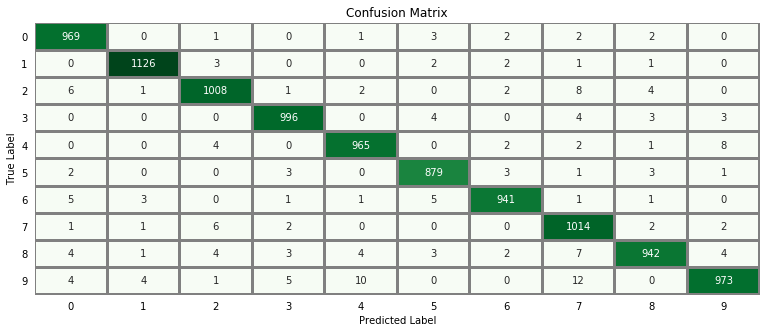

In [58]:
plt.figure(figsize = (13,5))
cf_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))
ax = sns.heatmap(cf_matrix, cmap='Greens',
                 cbar=False, annot=True, fmt='d', linewidths=2, linecolor='gray')
ax.tick_params(left=False, bottom=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()